In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
%matplotlib inline
import os

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('Chicago_hotels.csv', sep=';', skipfooter = 8,engine = 'python', decimal = ',')
df.head()

,date1,date2,x1,x2,x3,x4
0,January,1994,44.3,104.04,51.9,72.15
1,February,1994,54.7,102.74,60.1,73.47
2,March,1994,61.9,105.23,65.0,74.91
3,April,1994,69.1,113.63,69.8,79.06
4,May,1994,70.8,120.77,72.4,82.07


In [4]:
df=df.drop(columns=["x1", "x3","x4"])

Построим графики средней цены отеля за месяц. 

Text(0, 0.5, 'log10 от тысяч человек')

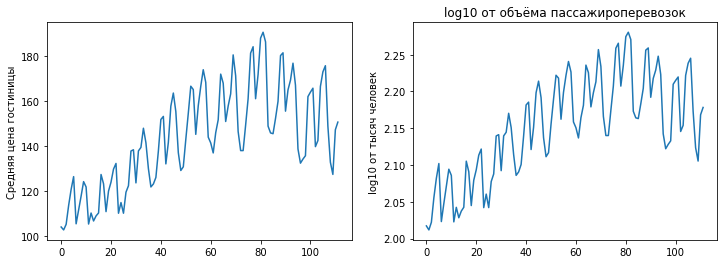

In [5]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)

df['x2'].plot(ax=ax1)
ax1.set_title(u'')
ax1.set_ylabel(u'Средняя цена гостиницы')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['x2'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')


Заметим, что на первом графике типа тренда квадратический или кубический, а сезонность мультипликативная.
Для логарифмов исходного ряда сезонность стала аддитивной, как видно на втором графике.
это подтверждает гипотезу о мультипликативном характере сезонности.

Построим модель линейной регрессии для прогнозирования логарифма от средней цены отеля. Используем формулу:
$$\log y_i = \alpha \cdot x^3_i + \beta \cdot x^2_i +\gamma \cdot x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- средняя цена отеля, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Создадим предиктор ```month_num``` -- порядковый номер наблюдения (номер месяца, считая от первого наблюдения).  Тем самым мы зададим линейный тренд. И прологарифмируем временной ряд.

In [6]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['x2'])
df['month_num_2'] = df['month_num']**2 
df['month_num_3'] = df['month_num']**3

In [7]:
#  Все хорошо?
df.head()

,date1,date2,x2,month_num,log_y,month_num_2,month_num_3
0,January,1994,104.04,1,2.017200,1,1
1,February,1994,102.74,2,2.011740,4,8
2,March,1994,105.23,3,2.022140,9,27
3,April,1994,113.63,4,2.055493,16,64
4,May,1994,120.77,5,2.081959,25,125


In [8]:
#  Эти переменные в модели не нужны
df_2 = df.drop(columns=["date1","date2", "x2"])

In [9]:
#  Все хорошо?
df_2.head()

,month_num,log_y,month_num_2,month_num_3
0,1,2.017200,1,1
1,2,2.011740,4,8
2,3,2.022140,9,27
3,4,2.055493,16,64
4,5,2.081959,25,125


In [10]:
print(df_2)

     month_num     log_y  month_num_2  month_num_3
0            1  2.017200            1            1
1            2  2.011740            4            8
2            3  2.022140            9           27
3            4  2.055493           16           64
4            5  2.081959           25          125
..         ...       ...          ...          ...
107        108  2.173041        11664      1259712
108        109  2.123492        11881      1295029
109        110  2.105306        12100      1331000
110        111  2.168262        12321      1367631
111        112  2.178171        12544      1404928

[112 rows x 4 columns]


Создадим новые переменные - индикаторы месяцев. Их 12*9 + 4 = 112

In [11]:
df_2["m01"] = [1,0,0,0,0,0,0,0,0,0,0,0]*9 + [1,0,0,0]
df_2["m02"] = [0,1,0,0,0,0,0,0,0,0,0,0]*9 + [0,1,0,0]
df_2["m03"] = [0,0,1,0,0,0,0,0,0,0,0,0]*9 + [0,0,1,0]
df_2["m04"] = [0,0,0,1,0,0,0,0,0,0,0,0]*9 + [0,0,0,1]
df_2["m05"] = [0,0,0,0,1,0,0,0,0,0,0,0]*9 + [0,0,0,0]
df_2["m06"] = [0,0,0,0,0,1,0,0,0,0,0,0]*9 + [0,0,0,0]
df_2["m07"] = [0,0,0,0,0,0,1,0,0,0,0,0]*9 + [0,0,0,0]
df_2["m08"] = [0,0,0,0,0,0,0,1,0,0,0,0]*9 + [0,0,0,0]
df_2["m09"] = [0,0,0,0,0,0,0,0,1,0,0,0]*9 + [0,0,0,0]
df_2["m10"] = [0,0,0,0,0,0,0,0,0,1,0,0]*9 + [0,0,0,0]
df_2["m11"] = [0,0,0,0,0,0,0,0,0,0,1,0]*9 + [0,0,0,0]
df_2["m12"] = [0,0,0,0,0,0,0,0,0,0,0,1]*9 + [0,0,0,0]

df_2.head(14)

,month_num,log_y,month_num_2,month_num_3,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,2.017200,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2,2.011740,4,8,0,1,0,0,0,0,0,0,0,0,0,0
2,3,2.022140,9,27,0,0,1,0,0,0,0,0,0,0,0,0
3,4,2.055493,16,64,0,0,0,1,0,0,0,0,0,0,0,0
4,5,2.081959,25,125,0,0,0,0,1,0,0,0,0,0,0,0
5,6,2.101953,36,216,0,0,0,0,0,1,0,0,0,0,0,0
6,7,2.023088,49,343,0,0,0,0,0,0,1,0,0,0,0,0
7,8,2.047625,64,512,0,0,0,0,0,0,0,1,0,0,0,0
8,9,2.071072,81,729,0,0,0,0,0,0,0,0,1,0,0,0
9,10,2.094226,100,1000,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
df_2.tail(14)

,month_num,log_y,month_num_2,month_num_3,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
98,99,2.132772,9801,970299,0,0,1,0,0,0,0,0,0,0,0,0
99,100,2.209703,10000,1000000,0,0,0,1,0,0,0,0,0,0,0,0
100,101,2.214976,10201,1030301,0,0,0,0,1,0,0,0,0,0,0,0
101,102,2.219611,10404,1061208,0,0,0,0,0,1,0,0,0,0,0,0
102,103,2.145507,10609,1092727,0,0,0,0,0,0,1,0,0,0,0,0
103,104,2.153876,10816,1124864,0,0,0,0,0,0,0,1,0,0,0,0
104,105,2.221649,11025,1157625,0,0,0,0,0,0,0,0,1,0,0,0
105,106,2.238247,11236,1191016,0,0,0,0,0,0,0,0,0,1,0,0
106,107,2.245068,11449,1225043,0,0,0,0,0,0,0,0,0,0,1,0
107,108,2.173041,11664,1259712,0,0,0,0,0,0,0,0,0,0,0,1


## Проверим кубический тренд

In [13]:
#  Создаем таблицу (столбец) откликов.
y = df_2['log_y']

In [14]:
#  Создаем матрицу предикторов.
#  Убираем из нее отклик и столбец индикаторов базового месяца
X = df_2.drop(columns=["log_y", "m03"])

In [15]:
#  Подгонка модели
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Коэффициенты модели

In [16]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,2.009213e+00
1,month_num,1.677953e-03
2,month_num_2,3.619885e-05
3,month_num_3,-3.706233e-07
4,m01,-1.796569e-02
5,m02,-2.441234e-02
6,m04,2.709682e-02
7,m05,6.555140e-02
8,m06,6.553045e-02
9,m07,4.279304e-03


In [17]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

Коэффициенты модели и проверка гипотез для них

In [18]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,2.009213e+00,0.000000e+00
1,month_num,1.677953e-03,5.870659e-04
2,month_num_2,3.619885e-05,3.086690e-04
3,month_num_3,-3.706233e-07,1.813029e-09
4,m01,-1.796569e-02,1.255184e-02
5,m02,-2.441234e-02,7.956085e-04
6,m04,2.709682e-02,2.137537e-04
7,m05,6.555140e-02,7.105427e-15
8,m06,6.553045e-02,7.105427e-15
9,m07,4.279304e-03,5.579383e-01


Смотрим на pvalue, гипотеза о равенстве нулю разности коэффициента данного месяца и базового m03 не отвергается только для m07, m12. Почему-то в марте, июле и августе поправки одинаковые. Зимой поправки минимальные, так как коэффициенты в эти месяцы отрицательные. Это можно объяснить тем, что зимой особо никто не хочет путешествовать.

<AxesSubplot:>

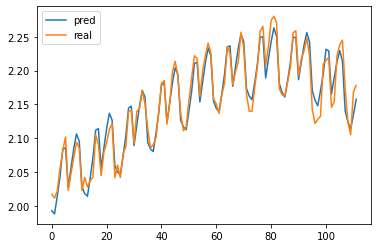

In [19]:
#  Сравним подгонку и ряд логарифмов

pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

## Прогнозирование.

In [20]:

#  Готовим маторицу значений предикторов df_3 
#  для вычисления прогнозов на 12 месяцев вперед
#  Сначала добавляем в нее время (номер месяца)
df_3 = pd.DataFrame()

df_3['month_num'] = range(113, 121)
df_3['month_num_2'] = [113**2,114**2,115**2,116**2,117**2,118**2,119**2,120**2]
df_3['month_num_3'] = [113**3,114**3,115**3,116**3,117**3,118**3,119**3,120**3]

In [21]:
print(df_3)

   month_num  month_num_2  month_num_3
0        113        12769      1442897
1        114        12996      1481544
2        115        13225      1520875
3        116        13456      1560896
4        117        13689      1601613
5        118        13924      1643032
6        119        14161      1685159
7        120        14400      1728000


In [22]:
#  Добавляем индикаторы месяцев. Базового месяца снова не должно быть
df_3["m01"] = [0,0,0,0,0,0,0,0]
df_3["m02"] = [0,0,0,0,0,0,0,0]
# df_3["m03"] = [0,0,0,0,0,0,0,0]
df_3["m04"] = [0,0,0,0,0,0,0,0]
df_3["m05"] = [1,0,0,0,0,0,0,0]
df_3["m06"] = [0,1,0,0,0,0,0,0]
df_3["m07"] = [0,0,1,0,0,0,0,0]
df_3["m08"] = [0,0,0,1,0,0,0,0]
df_3["m09"] = [0,0,0,0,1,0,0,0]
df_3["m10"] = [0,0,0,0,0,1,0,0]
df_3["m11"] = [0,0,0,0,0,0,1,0]
df_3["m12"] = [0,0,0,0,0,0,0,1]

In [23]:
#  Все хорошо?
df_3.head()

,month_num,month_num_2,month_num_3,m01,m02,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,113,12769,1442897,0,0,0,1,0,0,0,0,0,0,0
1,114,12996,1481544,0,0,0,0,1,0,0,0,0,0,0
2,115,13225,1520875,0,0,0,0,0,1,0,0,0,0,0
3,116,13456,1560896,0,0,0,0,0,0,1,0,0,0,0
4,117,13689,1601613,0,0,0,0,0,0,0,1,0,0,0


In [24]:
#  Прогноз для логарфмов
model.predict(df_3)

array([2.19182453, 2.1873752 , 2.12151455, 2.14383096, 2.16493131,
       2.17962615, 2.16137648, 2.08593168])

In [25]:
#  Прогноз для исходного ряда
y1 = 10**model.predict(df_3)

In [26]:
y1

array([155.53371029, 153.94840621, 132.28620242, 139.26146624,
       146.19459237, 151.2258911 , 145.00282912, 121.87978383])

Далее организуем данные для построения графика

In [27]:
#  матрица с подгонкой
pred['forecast'] = np.nan

In [28]:
#  Все хорошо?
pred.head()

,pred,real,forecast
0,1.992961,2.017200,NaN
1,1.988298,2.011740,NaN
2,2.014562,2.022140,NaN
3,2.043577,2.055493,NaN
4,2.084012,2.081959,NaN


In [29]:
#  матрица с прогнозом ()
#  порядок столбцов не важен. 
#  Имена столбцов должны быть как в матрице pred выше

df_4 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
df_4['real'] = np.nan
df_4['pred'] = np.nan


In [30]:
#  Все хорошо?
df_4.head()

,forecast,real,pred
0,2.191825,NaN,NaN
1,2.187375,NaN,NaN
2,2.121515,NaN,NaN
3,2.143831,NaN,NaN
4,2.164931,NaN,NaN


<AxesSubplot:>

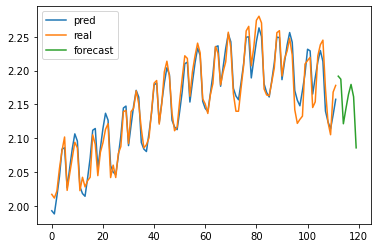

In [31]:
#  объединяем матрицы, задаем новые индексы
pred_1 = pd.concat(
    [pred, df_4],
    sort=False
).reset_index(drop=True)

pred_1.plot()

In [32]:
#  Возвращаемся к исходному ряду
pred_11 = 10**pred_1

<AxesSubplot:>

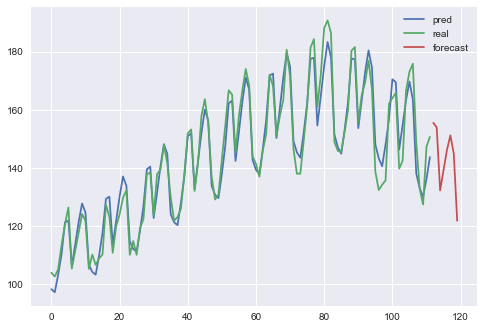

In [33]:
matplotlib.style.use('seaborn')
pred_11.plot()